<a href="https://colab.research.google.com/github/hecshzye/food-recognizer-research-paper/blob/main/Food_recognizer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food-recognizer computer vision modelling

### A computer vision model trained on dataset from TensorFlow Datasets
- Training data = 75750 images
- Testing data = 25,250 images
- Using mixed precision

### Goals
- The goal is to match or beat the `DeepFood Research Paper` - https://arxiv.org/abs/1606.05675
- Researchers used a `Convolutional Neural Network`.
- Trained the model for couple of days
- The `top accuracy` achieved was `77.4%`
- The research focused on Computer-Aided Dietary Assesment
- It states the following concerns 
  - "Worldwide, in 2014, almost 2 billion adults, 18+, were overweight. Of these, over 600 million were obese. 
  - Accurately documenting dietary caloric intake is crucial to manage weight loss, but also presents challenges because most of the current methods for dietary assessment must rely on memory to recall foods eaten. 
  - The ultimate goal of the research is to develop a computer-aided techinical solutions to enhance and improve the accuracy of current measurements of dietary intake. 
  - The proposed system in this paper aims to improve the accuracy of dietary assessment by analyzing food images captured by mobile devices. 
  - The key techinique innovation in this paper is the deep learning based food image recognitiion algorithms. Substantial research has demonstrated that digital imaging accurately estimates dietary intake in many environments and it has many advantages over other methods.


In [21]:
# GPU for mixed precision and training
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-037b2134-a899-afba-1288-d4a987a12ee8)


In [2]:
# Importing 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow_datasets as tfds 

In [4]:
# Using helper functions for ease and simplicity
import os
if not os.path.exists("helper_functions.py"):
  print("Available")
  !wget https://raw.githubusercontent.com/hecshzye/food-or-not-model/main/helper_functions.py
else:
  print("already exists")  

already exists


In [5]:
from helper_functions import load_prepare_images, create_confusion_matrix, pred_plot, create_tensorboard_callback, plot_loss_curves, compare_history, unzip_data, walk_dir, calculate_results

## Importing dataset from tensorflow dataset

In [6]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [7]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete2RSSW3/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete2RSSW3/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


 ### Exploratory Data Analysis

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
class_names = ds_info.features["label"].names
class_names[:20]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

In [10]:
# EDA in small sample size 
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [11]:
# Output info
for image, label in train_one_sample:
  print(f"""
  image shape: {image.shape}
  dtype: {image.dtype}
  target class: {label}
  Class name: {class_names[label.numpy()]}
         """)


  image shape: (512, 512, 3)
  dtype: <dtype: 'uint8'>
  target class: 16
  Class name: cheesecake
         


In [12]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [13]:
# Range
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

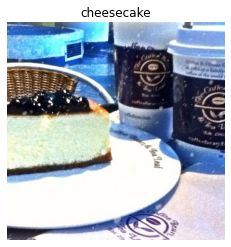

In [14]:
# Sample plotting
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

Nice 🤤 😋 🥺

### Preprocessing and batching the dataset 

In [15]:
# Function for preprocessing (unit8 to float32, faster computation)
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [16]:
# Preprocessing sample image
preprocessed_img = preprocess_img(image, label)[0]
print(f" before:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f" after:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

 before:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

 after:
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]...,
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


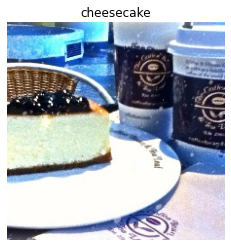

In [17]:
# plotting the sample image
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

In [18]:
# Mapping preprocessed function to training data
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
# Test data preprocessing
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

#### Callbacks 

In [19]:
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=1)

## Using Mixed Precision Training

In [22]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [23]:
mixed_precision.global_policy()

<Policy "mixed_float16">

### Feature Exraction Modelling

In [24]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# Freezing the model layers
base_model.trainable = False 

# Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer", dtype=tf.float16)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

# Activation of output layer serperation for float32 activation
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [26]:
# Reassuring layer dtype policies for mixed precision
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float16 <Policy "float16">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [27]:
# layer dtype policies (base_model)
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

### Fitting the feature extraction model

In [28]:
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saved Tensorboard logs to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220113-041113


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8226 - accuracy: 0.5569
Epoch 00001: val_accuracy improved from -inf to 0.67691, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 197s 76ms/step - loss: 1.8226 - accuracy: 0.5569 - val_loss: 1.2330 - val_accuracy: 0.6769
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2933 - accuracy: 0.6668
Epoch 00002: val_accuracy improved from 0.67691 to 0.69518, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 178s 74ms/step - loss: 1.2932 - accuracy: 0.6669 - val_loss: 1.1232 - val_accuracy: 0.6952
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1426 - accuracy: 0.7014
Epoch 00003: val_accuracy improved from 0.69518 to 0.71213, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 172s 72ms/step - loss: 1.1427 - accuracy: 0.7014 - val_loss: 1.0740 - val_accuracy: 0.712

### Evaluation

In [29]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 53s 66ms/step - loss: 1.0886 - accuracy: 0.7065


[1.0885964632034302, 0.7064950466156006]

In [30]:
# Evaluating the checkpoint weights by cloning the model
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [31]:
!ls model_checkpoints/

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [32]:
checkpoint_path

'model_checkpoints/cp.ckpt'

In [33]:
cloned_model.load_weights(checkpoint_path)

In [34]:
# Recompiling
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [35]:
# Evaluation of cloned model
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 54s 65ms/step - loss: 1.7176 - accuracy: 0.5487


In [36]:
# Checking two chekcpint weights (before & after)
assert np.isclose(results_feature_extract_model, results_cloned_model_with_loaded_weights).all()

AssertionError: ignored

Weights were not accounted

In [37]:
# Checking the dtype policy of the previous base model
for layer in cloned_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

In [38]:
# Saving the model to drive
save_dir = "drive/MyDrive/CNN-Computer-vision-data/01_efficientnetb0_feature_etract_model_mixed_precision/"
os.makedirs(save_dir)
model.save(save_dir)

INFO:tensorflow:Assets written to: drive/MyDrive/CNN-Computer-vision-data/01_efficientnetb0_feature_etract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: drive/MyDrive/CNN-Computer-vision-data/01_efficientnetb0_feature_etract_model_mixed_precision/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [39]:
# Locally for faster computation
save_dir1 = "01_efficientnetb0_feature_extract_model_mixed_pricision"
model.save(save_dir1)

INFO:tensorflow:Assets written to: 01_efficientnetb0_feature_extract_model_mixed_pricision/assets


INFO:tensorflow:Assets written to: 01_efficientnetb0_feature_extract_model_mixed_pricision/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [41]:
# Loading saved model
loaded_saved_model = tf.keras.models.load_model(save_dir1)

In [42]:
# Checking the dtype policy
for layer in loaded_saved_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

In [44]:
# Checking results
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 54s 67ms/step - loss: 1.0886 - accuracy: 0.7065


[1.0885957479476929, 0.7064950466156006]

In [45]:
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

The model is performing optimally without any errors

### Fine tuning

In [48]:
loaded_saved_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [49]:
# Checking results
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 53s 67ms/step - loss: 1.0886 - accuracy: 0.7065


[1.0885957479476929, 0.7064950466156006]

In [50]:
# Checking for any frozen layers
for layer in loaded_saved_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float16 <Policy "float16">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [52]:
# Chekcing the layers in the base model 
for layer in loaded_saved_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "mixed_float16">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed

## Callbakcs

In [53]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [58]:
# Learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [59]:
# Compiling the model
loaded_saved_model.compile(loss="sparse_categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(0.0001),
                           metrics=["accuracy"])

In [60]:
# Fitting the data
history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data,
                                                                     epochs=100,
                                                                     steps_per_epoch=len(train_data),
                                                                     validation_data=test_data,
                                                                     validation_steps=int(0.15 * len(test_data)),
                                                                     callbacks=[create_tensorboard_callback("training_logs", "efficientnetb0_101_classes_all_data_fine_tuning"),
                                                                                model_checkpoint,
                                                                                early_stopping,
                                                                                reduce_lr])

Saved Tensorboard logs to: training_logs/efficientnetb0_101_classes_all_data_fine_tuning/20220113-050951
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - ETA: 0s - loss: 0.9215 - accuracy: 0.7536INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 411s 166ms/step - loss: 0.9215 - accuracy: 0.7536 - val_loss: 0.8070 - val_accuracy: 0.7733 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5784 - accuracy: 0.8402INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 391s 164ms/step - loss: 0.5784 - accuracy: 0.8402 - val_loss: 0.7770 - val_accuracy: 0.7889 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 339s 142ms/step - loss: 0.3308 - accuracy: 0.9067 - val_loss: 0.8816 - val_accuracy: 0.7773 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1730 - accuracy: 0.9495
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 341s 143ms/step - loss: 0.1730 - accuracy: 0.9495 - val_loss: 0.9373 - val_accuracy: 0.7868 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 338s 142ms/step - loss: 0.0360 - accuracy: 0.9916 - val_loss: 1.0443 - val_accuracy: 0.8048 - lr: 2.0000e-05


In [61]:
# Saving the model 
loaded_saved_model.save("/content/drive/MyDrive/CNN-Computer-vision-data/02_efficientnetb0_fine_tuned_101_classes_mixed_precision/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CNN-Computer-vision-data/02_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/CNN-Computer-vision-data/02_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [62]:
# Saving locally for faster access
loaded_saved_model.save("02_efficientnetb0_fine_tuned_101_classes_mixed_precision")

INFO:tensorflow:Assets written to: 02_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: 02_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [63]:
# Evaluation
results_loaded_saved_model_fine_tuned = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model_fine_tuned

790/790 [==============================] - 54s 68ms/step - loss: 1.0473 - accuracy: 0.7999


[1.0473191738128662, 0.7999207973480225]

Accuracy achieved = **79.999%**

Beating the DeepFood research paper **(77.4%)**

In [64]:
# Tensorboard
!tensorboard dev upload --logdir ./training_logs \
--name "Fine-tuning EfficientNetb0 on all Food101 Data" \
--description "Training results for fine tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=oedKnHanCvSWj20TMQbFRJKalD4vBx&prompt=consent&access_type=offli

### Tensorboard uploaded 

Link to tensorboard developer: https://tensorboard.dev/experiment/g0RluvzpQA2gxNYnilR5Zw/#scalars

In [65]:
!tensorboard dev list

https://tensorboard.dev/experiment/g0RluvzpQA2gxNYnilR5Zw/
	Name                 Fine-tuning EfficientNetb0 on all Food101 Data
	Description          Training results for fine tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   g0RluvzpQA2gxNYnilR5Zw
	Created              2022-01-13 06:05:54 (14 minutes ago)
	Updated              2022-01-13 06:05:57 (14 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              48
	Tensor bytes         0
	Binary object bytes  2058461
Total: 1 experiment(s)
